# Лабораторная работа №8. 
## Рекуррентные нейронные сети для анализа временных рядов


### Данные: 
Набор данных для прогнозирования временных рядов, который состоит из среднемесячного числа пятен на солнце, наблюдаемых с января 1749 по август 2017. Данные в виде csv-файла можно скачать на сайте Kaggle -> https://www.kaggle.com/robervalt/sunspots/

### Задания
- [x] Загрузите данные. 
- [x] Изобразите ряд в виде графика. 
- [x] Вычислите основные характеристики временного ряда (сезонность, тренд, автокорреляцию).
- [x] Для прогнозирования разделите временной ряд на обучающую, валидационную и контрольную выборки.
- [ ] Примените модель ARIMA для прогнозирования значений данного временного ряда.
- [ ] Повторите эксперимент по прогнозированию, реализовав рекуррентную нейронную сеть (с как минимум 2 рекуррентными слоями).
- [ ] Сравните качество прогноза моделей.

In [0]:
import os

import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import keras as K
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

### Parse Data

In [0]:
data_dir = Path('/content')

# Load Data 
df = pd.read_csv(data_dir / 'Sunspots.csv', parse_dates=['Date'], index_col=['Date'])
df.drop(columns=['Unnamed: 0'], inplace=True)

df.index.freq

In [52]:
df.tail()

Monthly Mean Total Sunspot Number
Date                                         
2019-08-31                                0.5
2019-09-30                                1.1
2019-10-31                                0.4
2019-11-30                                0.5
2019-12-31                                1.6

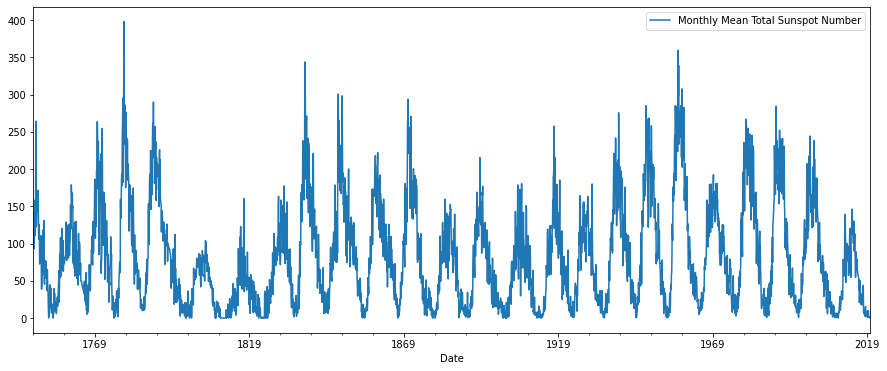

In [53]:
# Plot Data
df.plot.line(figsize=(15, 6))

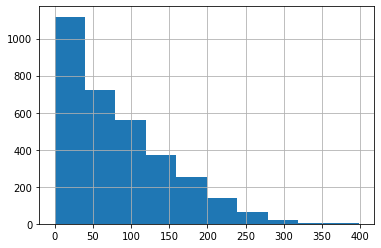

In [54]:
df['Monthly Mean Total Sunspot Number'].hist()

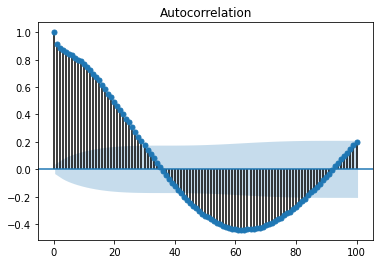

In [55]:
# Plot ACF
fig = sm.graphics.tsa.plot_acf(df['Monthly Mean Total Sunspot Number'], lags=100)

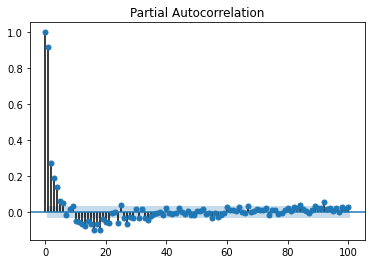

In [56]:
# Plot PACF
fig = sm.graphics.tsa.plot_pacf(df['Monthly Mean Total Sunspot Number'], lags=100)

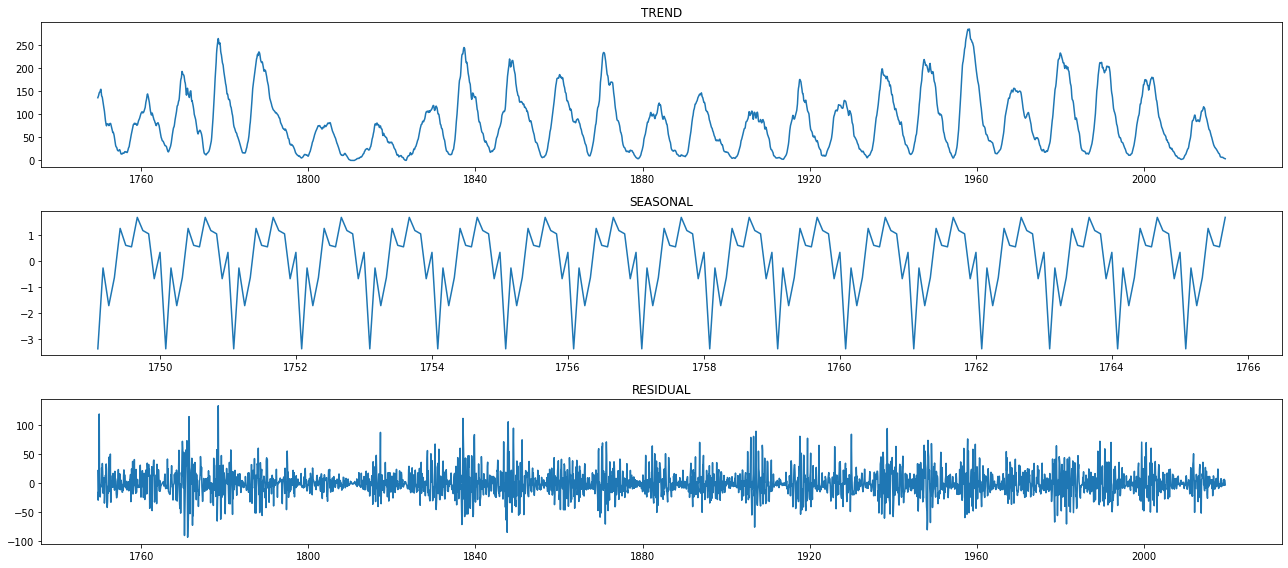

In [57]:
# Decompose y(t) = TREND + SEASONAL + RESIDUAL
attrs = sm.tsa.seasonal_decompose(df['Monthly Mean Total Sunspot Number'])

_, ax = plt.subplots(3, 1, figsize=(18, 8))

ax[0].plot(attrs.trend)
ax[0].set_title('TREND')

ax[1].plot(attrs.seasonal[:200])
ax[1].set_title('SEASONAL')

ax[2].plot(attrs.resid)
ax[2].set_title('RESIDUAL')

plt.tight_layout()

Train shape: (1829, 1)
Val   shape: (610, 1)
Test  shape: (813, 1)


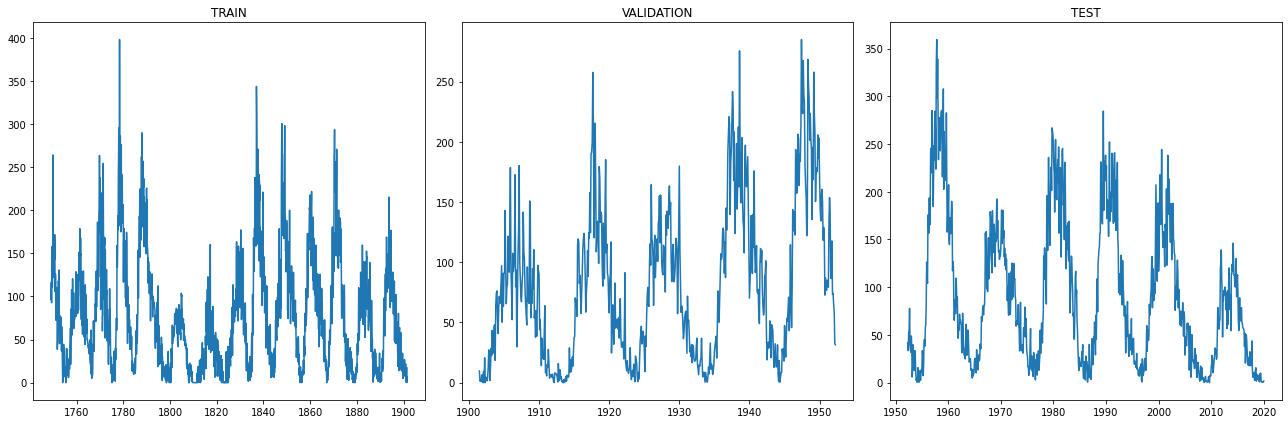

In [58]:
# Split DafaFrame
train_df, test_df = train_test_split(df, shuffle=False)
train_df, val_df = train_test_split(train_df, shuffle=False)

print('Train shape:', train_df.shape)
print('Val   shape:', val_df.shape)
print('Test  shape:', test_df.shape)

_, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].plot(train_df)
ax[0].set_title('TRAIN')

ax[1].plot(val_df)
ax[1].set_title('VALIDATION')

ax[2].plot(test_df)
ax[2].set_title('TEST')

plt.tight_layout()

### ARIMA model

In [0]:
from statsmodels.tsa.arima_model import ARIMA

In [0]:
val_history = train_df['Monthly Mean Total Sunspot Number'].to_list()
val_predictions = []
for row in val_df.values:
  model = ARIMA(val_history, order=(7, 1, 0)).fit()
  y = model.forecast()[0]
  
  val_predictions.append(y)
  val_history.append(row)

697.4508216555337

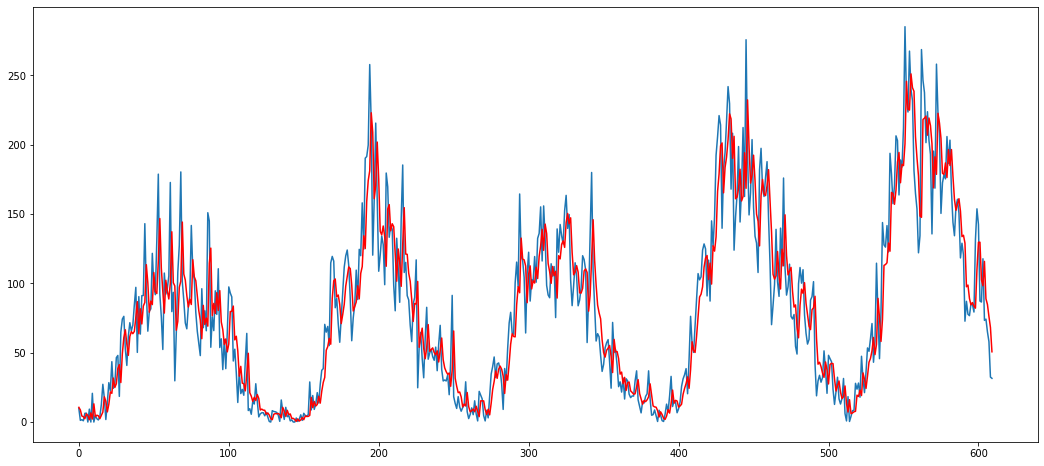

In [121]:
# Plot Validation predictions
_, ax = plt.subplots(1, 1, figsize=(18, 8))

ax.plot(val_df.values)
ax.plot(val_predictions, color='red')

# MSE
mean_squared_error(val_df, val_predictions)

In [0]:
# Test
test_history = train_df['Monthly Mean Total Sunspot Number'].to_list()
test_predictions = []
for row in test_df.values:
  model = ARIMA(test_history, order=(7, 1, 0)).fit()
  y = model.forecast()[0]
  test_predictions.append(y)
  test_history.append(row)

572.2702751877127

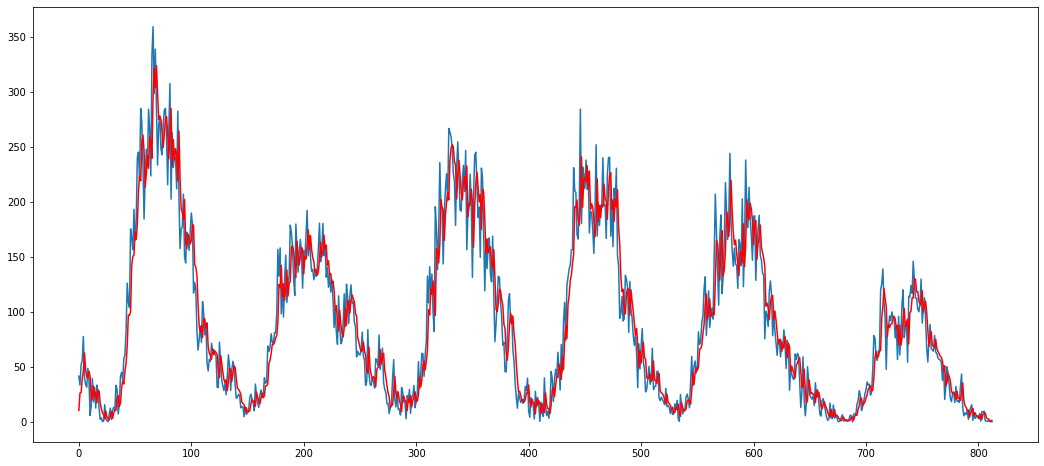

In [125]:
# Plot test predictions 
_, ax = plt.subplots(1, 1, figsize=(18, 8))

ax.plot(test_df.values)
ax.plot(test_predictions, color='red')

# MSE
mean_squared_error(test_df, test_predictions)

### RNN Model

In [0]:
train_df, test_df = train_test_split(df, shuffle=False)

In [0]:
def mk_dataset(df, window_size):
  X, Y = [], []
  for i in range(len(df) - window_size - 1):
    last_row_idx = i + window_size
    x = df[i:last_row_idx].values
    X.append(x)
    Y.append(df.values[last_row_idx, 0])
  return np.array(X), np.array(Y)

In [202]:
WIN_SIZE = 32

train_X, train_Y = mk_dataset(train_df, window_size=WIN_SIZE)
test_X, test_Y = mk_dataset(test_df, window_size=WIN_SIZE)


print("Train X:", train_X.shape)
print("Train Y:", train_Y.shape)

print("Test X:", test_X.shape)
print("Test Y:", test_Y.shape)

Train X: (2406, 32, 1)
Train Y: (2406,)
Test X: (780, 32, 1)
Test Y: (780,)


In [203]:
model = K.models.Sequential([
  K.layers.LSTM(8, input_shape=(WIN_SIZE, 1), return_sequences=True),
  K.layers.LSTM(8),
  K.layers.Dense(1, activation='linear')
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 32, 8)             320       
_________________________________________________________________
lstm_20 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 9         
Total params: 873
Trainable params: 873
Non-trainable params: 0
_________________________________________________________________


In [204]:
history = model.fit(
    train_X, train_Y,
    epochs=500, 
    validation_data=(test_X, test_Y)
)

Train on 2406 samples, validate on 780 samples
Epoch 1/500
2406/2406 [==============================] - 2s 1ms/step - loss: 10248.1153 - mse: 10248.1172 - val_loss: 14390.9702 - val_mse: 14390.9688
Epoch 2/500
2406/2406 [==============================] - 2s 713us/step - loss: 9930.0141 - mse: 9930.0137 - val_loss: 14048.4645 - val_mse: 14048.4639
Epoch 3/500
2406/2406 [==============================] - 2s 723us/step - loss: 9717.8983 - mse: 9717.8965 - val_loss: 13838.8308 - val_mse: 13838.8320
Epoch 4/500
2406/2406 [==============================] - 2s 710us/step - loss: 9565.1982 - mse: 9565.1973 - val_loss: 13673.3962 - val_mse: 13673.3975
Epoch 5/500
2406/2406 [==============================] - 2s 718us/step - loss: 9438.8312 - mse: 9438.8311 - val_loss: 13527.4106 - val_mse: 13527.4102
Epoch 6/500
2406/2406 [==============================] - 2s 721us/step - loss: 9323.7253 - mse: 9323.7266 - val_loss: 13391.6709 - val_mse: 13391.6719
Epoch 7/500
2406/2406 [========================

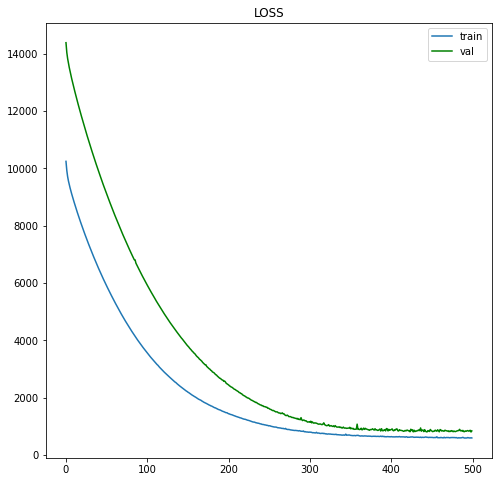

In [205]:
def plot_history(history):
    _, ax = plt.subplots(1, 1, figsize= (8, 8))

    ax.set_title('LOSS')
    ax.plot(history.history['mse'])
    ax.plot(history.history['val_mse'], color='green')
    ax.legend(['train', 'val'], loc='best')

plot_history(history)

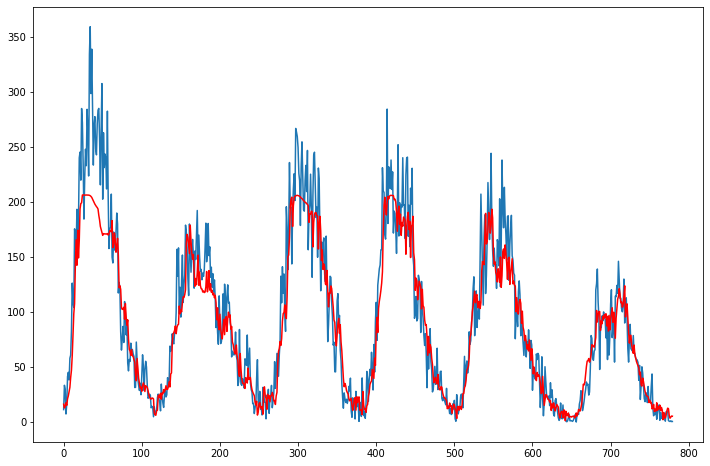

In [211]:
# Plot test Y
predictions = model.predict(test_X)

_, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.plot(test_Y)
ax.plot(predictions, color='red')